# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *   #adds ~107MB
from fastai.text import *    #adds ~6MB
# from fastai.callbacks.tracker import *

In [3]:
PATH = Path('data/IAM_handwriting')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
def size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    sz = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return sz

def print_size_of_model(model):
    print('%.2f MB' % size_of_model(model))

# Data

## word combo

In [ ]:
fname = 'edited_sm_synth.csv'
CSV = PATH/fname
FOLDER = 'edited_sm_synth'

df = pd.read_csv(CSV)
len(df)

In [ ]:
sz,bs = 256,50
seq_len,word_len = 100,50

## font generated

In [ ]:
#font generated
fname = 'font_mix_129k.csv'
FOLDER = 'combo_cat'

In [ ]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

## handwriting

In [ ]:
#handwriting only
fname = 'hand_mix_25k.csv'
FOLDER = 'combo_cat'

In [ ]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

## paragraphs

In [ ]:
fname = 'edited_pg.csv'
FOLDER = 'paragraphs'

In [ ]:
CSV = PATH/fname
df = pd.read_csv(CSV)

sz,bs = 512,15
seq_len,word_len = 750,300
len(df)

# ModelData

In [10]:
tfms = get_transforms(do_flip=False, max_zoom=1, max_rotate=2, max_warp=0.1, max_lighting=0.5)

def force_gray(image): return image.convert('L').convert('RGB')

## SentencePiece

In [6]:
import sentencepiece as spm

# sp = spm.SentencePieceProcessor()
# sp.Load(str(PATH/'spm_full_10k.model'))
# sp.SetEncodeExtraOptions("eos")
# sp.SetDecodeExtraOptions("bos:eos")

In [7]:
def add_cap_tokens(text):  # before encode
    re_caps = re.compile(r'[A-Z]+')
    return re_caps.sub(_replace_caps, text)
    
def _replace_caps(m):
    tok = '[UP]' if m.end()-m.start() > 1 else '[MAJ]'
    return tok + m.group().lower()

def remove_cap_tokens(text):  # after decode
    text = re.sub(r'\[UP\]\w+', lambda m: m.group()[4:].upper(), text)  #cap entire word
    text = re.sub(r'\[MAJ\]\w?', lambda m: m.group()[5:].upper(), text) #cap first letter
    return text

## Word only (export)

In [11]:
def label_collater(samples:BatchSamples, pad_idx:int=0):
    "Function that collect samples and pads ends of labels."
    data = to_data(samples)
    ims, lbls = zip(*data)
    imgs = torch.stack(list(ims))
    if len(data) is 1 and lbls[0] is 0:   #predict
        labels = torch.zeros(1,1).long()
        return imgs, labels    
    max_len = max([len(s) for s in lbls])
    labels = torch.zeros(len(data), max_len+1).long() + pad_idx  # add 1 to max_len to account for bos token
    for i,lbl in enumerate(lbls):
        labels[i,:len(lbl)] = torch.from_numpy(lbl)  #padding end    
    return imgs, labels

In [8]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.Load(f'{model_prefix}.model')
        self.tok.SetEncodeExtraOptions("eos")

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsIds(t)[1:]
      
class CustomTokenizer():
    def __init__(self, tok_func:Callable, model_prefix:str):
        self.tok_func, self.model_prefix = tok_func,model_prefix
        self.pre_rules = [rm_useless_spaces, add_cap_tokens]
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_one(self, t:str, tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t) 
        return toks 
                                                                         
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`." 
        tok = self.tok_func(self.model_prefix)
        return [self.process_one(t, tok) for t in texts]

In [9]:
class SPList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        model_prefix = self.path/'spm_full_10k'
        cust_tok = CustomTokenizer(SPTokenizer, model_prefix)
        self.processor = TokenizeProcessor(tokenizer=cust_tok, include_bos=False)
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(model_prefix)+'.model')
        self.sp.SetDecodeExtraOptions("bos:eos")
        
        self.pad_idx = 0
        self.copy_new += ['sp']
    
    def get(self, i):
        o = self.items[i]
        return Text(o, self.textify(o))
    
    def reconstruct(self, t:Tensor):
        nonzero_idxs = (t != self.pad_idx).nonzero()
        idx_min = 0
        idx_max = nonzero_idxs.max() if len(nonzero_idxs) > 0 else 0
        return Text(t[idx_min:idx_max+1], self.textify(t[idx_min:idx_max+1]))

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)        
    
    def textify(self, ids):
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        st = self.sp.DecodeIds(ids)
        st = remove_cap_tokens(st)
        return st

In [ ]:
data = (ImageList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)    # ~245MB
        .split_by_rand_pct(valid_pct=0.15, seed=42)
        .label_from_df(label_cls=SPList)
        .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=label_collater)
       )

In [ ]:
# export only the data for use with the final jit graphed model
# can't export them together because TorchScript model doesn't allow pickling

# data.valid_ds.export('data.pkl')

In [ ]:
# data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(18,10))

## Test Data

In [ ]:
FOLDER = 'uploads'
df = pd.read_csv(PATH/'uploads.csv')
len(df)

sz,bs = 512,14

In [12]:
FOLDER = 'paragraphs'
df = pd.read_csv(PATH/'test_pg.csv')
len(df)

sz,bs = 512,15

In [13]:
data = (ImageList.from_df(df, path=PATH, folder=FOLDER, after_open=force_gray)    # ~245MB
        .split_none()
        .label_from_df(label_cls=SPList)
        .transform([], size=sz, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs, device=device, collate_fn=label_collater)
       )

# Transformer Modules

In [30]:
# LayerNorm = nn.LayerNorm
LayerNorm = partial(nn.LayerNorm, eps=1e-4)  # eps: 1e-4 accomodates mixed precision training

In [31]:
# class SublayerConnection(nn.Module):
#     "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
#     def __init__(self, size, dropout):
#         super(SublayerConnection, self).__init__()
#         self.norm = LayerNorm(size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, sublayer):
#         return x + self.dropout(sublayer(self.norm(x)))

In [32]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

In [33]:
class Encoder(nn.Module):
    __constants__ = ['layers']
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [34]:
# class EncoderLayer(nn.Module):
#     "Encoder: self-attn and feed forward"
#     def __init__(self, size, self_attn, feed_forward, dropout):
#         super(EncoderLayer, self).__init__()
#         self.size = size
#         self.self_attn = self_attn
#         self.feed_forward = feed_forward
#         self.sublayer = clones(SublayerConnection(size, dropout), 2)

#     def forward(self, x, mask=None):
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
#         return self.sublayer[1](x, self.feed_forward)

In [35]:
class Decoder(nn.Module):
    __constants__ = ['layers']
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [36]:
# class DecoderLayer(nn.Module):
#     "Decoder: self-attn, src-attn, and feed forward"
#     def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
#         super(DecoderLayer, self).__init__()
#         self.size = size
#         self.self_attn = self_attn
#         self.src_attn = src_attn
#         self.feed_forward = feed_forward
#         self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
#     def forward(self, x, src, tgt_mask=None):
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # acts as a weak LM
#         x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
#         return self.sublayer[2](x, self.feed_forward)

In [37]:
# def attention(query, key, value, mask=None, dropout=None):
#     "Compute 'Scaled Dot Product Attention'"
#     depth = query.size(-1)
#     scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, -1e4)  #changed from: -1e9 to accomodate mixed precision  
#     p_attn = F.softmax(scores, dim=-1)
#     if dropout is not None:
#         p_attn = dropout(p_attn)
#     return torch.matmul(p_attn, value), p_attn

In [38]:
# class SingleHeadedAttention(nn.Module):
#     def __init__(self, d_model, dropout=0.2):
#         super(SingleHeadedAttention, self).__init__()
#         self.linears = clones(nn.Linear(d_model, d_model), 4)
#         self.attn = None
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, query, key, value, mask=None):        
#         query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
#         x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
#         return self.linears[-1](x)

In [39]:
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, d_model, h=8, dropout=0.2):
#         super(MultiHeadedAttention, self).__init__()
#         assert d_model % h == 0
#         self.d_k = d_model // h        # assume d_v always equals d_k
#         self.h = h
#         self.linears = clones(nn.Linear(d_model, d_model), 4)
#         self.attn = None
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, q, k, v, mask=None):
#         if mask is not None: mask = mask.unsqueeze(1)
#         bs = q.size(0)
        
#         # 1) Do all the linear projections in batch from d_model => h x d_k 
#         q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (q, k, v))]
        
#         # 2) Apply attention on all the projected vectors in batch. 
#         x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
#         # 3) "Concat" using a view and apply a final linear. 
#         x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
#         return self.linears[-1](x)

In [40]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

In [41]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=2000):
#         super(PositionalEncoding, self).__init__()
        
#         self.dropout = nn.Dropout(p=dropout)
        
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0.0, max_len).unsqueeze(1)
#         log_increment = math.log(1e4) / d_model
#         div_term = torch.exp(torch.arange(0.0, d_model, 2) * -log_increment)  
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe.unsqueeze_(0)

#         self.register_buffer('pe', pe)    #(1,max_len,d_model)
#         # registered buffers are Tensors (not Variables)
#         # not a parameter but still want in the state_dict

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1)]
#         return self.dropout(x)

In [42]:
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

# Convert to Graph (via JIT)

## No Static Quantization (only dynamic)

In [43]:
class ResnetBase(nn.Module):
    def __init__(self):
        super().__init__()

        net = models.resnet18(True)
        modules = list(net.children())[:-2]
        self.base = nn.Sequential(*modules)                  #32x32 : 256
        
    def forward(self, x):
        return self.base(x)

## Adjust modules for Quantization

In [ ]:
from torchvision.models.quantization import resnet18 as qresnet18

In [ ]:
class ResnetBase(nn.Module):
    def __init__(self):
        super().__init__()

        net = qresnet18(True)
        modules = list(net.children())[:-4]
        self.base = nn.Sequential(*modules)                  #32x32 : 256
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.base(x)
        return self.dequant(x)

## Adjust modules for TorchScript

In [44]:
class LearnedPositionalEmbeddings(nn.Module):
    __constants__ = ['nl_tok', 'd_model']
    
    def __init__(self, d_model, vocab, dropout=0.0):
        super(LearnedPositionalEmbeddings, self).__init__()
        self.nl_tok  = 4
        self.d_model = d_model

        self.embed = nn.Embedding(vocab, d_model, 0)
        self.rows = nn.Embedding(15, d_model//2, 0)
        self.w_cols = nn.Embedding(60, d_model//2, 0)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):  # x: [bs, sl]
        rows,cols = self.encode_spatial_positions(x)
        
        row_t = self.rows(rows)            
        col_t = self.w_cols(torch.clamp(cols, max=self.w_cols.num_embeddings-1))  # clamp to max column value
        pos_enc = torch.cat((row_t, col_t), dim=-1)
                
        x = self.embed(x)
        x = (x + pos_enc) * math.sqrt(self.d_model)
        return self.dropout(x)
    
    def encode_spatial_positions(self, x):
        rows,cols = torch.zeros_like(x),torch.zeros_like(x)
        ii = 0
        for batch in x.unbind():
            nls = torch.nonzero(batch==self.nl_tok).flatten()
            last = torch.nonzero(batch).flatten()[-1][None]
            splits = torch.cat([nls,last])

            p=0
            for i in range(len(splits)):
                n = int(splits[i].item())
                rows[ii,p:n+1] = i+1
                cols[ii,p:n+1] = torch.arange(1,n-p+2)
                p = n+1

            ii+=1
        return rows,cols

In [45]:
# lpe = LearnedPositionalEmbeddings(512, 10000)
# lpe.load_state_dict(lpe_sd)
# lpe.eval()
# lpe_trace = torch.jit.script(lpe)

# torch.testing.assert_allclose(lpe(y), lpe_trace(y))

In [46]:
class Adaptor(nn.Module):
    def forward(self, x):
        x = x.flatten(2,3).permute(0,2,1)
        return x.mul(8)

In [47]:
class MultiHeadedAttention(nn.Module):
    __constants__ = ['h', 'd_k']
    
    def __init__(self, d_model, h=8, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h

        self.linear0 = nn.Linear(d_model, d_model)
        self.linear1 = nn.Linear(d_model, d_model)
        self.linear2 = nn.Linear(d_model, d_model)
        self.linear3 = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask:Optional[torch.Tensor]=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        q = self.linear0(q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        k = self.linear1(k).view(bs, -1, self.h, self.d_k).transpose(1,2)
        v = self.linear2(v).view(bs, -1, self.h, self.d_k).transpose(1,2)
        
        # 2) Apply attention on all the projected vectors in batch. 
        x = self.attention(q, k, v, mask=mask)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linear3(x)
    
    def attention(self, query, key, value, mask:Optional[torch.Tensor]=None):
        depth = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)  #changed from: -1e9 to accomodate mixed precision  
        p_attn = F.softmax(scores, dim=-1)
        return torch.matmul(self.dropout(p_attn), value)

In [48]:
# ex = torch.rand(2,3,512)

# mha = MultiHeadedAttention(512).eval()   #.eval() here is critical otherwise dropout still adds randomness
# mha_trace = torch.jit.script(mha)

# torch.testing.assert_allclose(mha(ex,ex,ex), mha_trace(ex,ex,ex))

In [49]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        
        self.norm0 = LayerNorm(size)
        self.dropout0 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(size)
        self.dropout1 = nn.Dropout(dropout)
        
    def forward(self, x):
        y = self.norm0(x)
        x = x + self.dropout0(self.self_attn(y,y,y))
        
        y = self.norm1(x)
        x = x + self.dropout1(self.feed_forward(y))
        return x

In [50]:
# ff = PositionwiseFeedForward(512)
# enc = EncoderLayer(512, mha, ff, 0.1).eval()
# enc_trace = torch.jit.script(enc)

# torch.testing.assert_allclose(enc(ex), enc_trace(ex))

In [51]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        
        self.norm0 = LayerNorm(size)
        self.dropout0 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(size)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = LayerNorm(size)
        self.dropout2 = nn.Dropout(dropout)
         
    def forward(self, x, src, mask):
        y = self.norm0(x)
        x = x + self.dropout0(self.self_attn(y,y,y,mask))
        
        y = self.norm1(x)
        x = x + self.dropout1(self.src_attn(y,src,src))
        
        y = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(y))
        return x

In [52]:
# remove explicit calls to device for scripting (inference on CPU only)

def rshift(tgt, bos_token:int=1):
    "Shift y to the right by prepending token"
    bos = torch.zeros((tgt.size(0),1)).type_as(tgt) + bos_token
    return torch.cat((bos, tgt[:,:-1]), dim=-1)

def subsequent_mask(size:int):
    return torch.tril(torch.ones((1,size,size)).byte())

In [53]:
class WordTransformer(nn.Module):
    def __init__(self, encoder, decoder, embeddings, generator):
        super(WordTransformer, self).__init__()
        self.encoder = encoder
        self.w_decoder = decoder
        self.embed = embeddings
        self.generator = generator
            
    def forward(self, src, tgt):
        tgt = rshift(tgt, 1).long()
        mask = subsequent_mask(tgt.size(-1))
        return self.w_decoder(self.embed(tgt), self.encoder(src), mask)

    @torch.jit.export
    def generate(self, outs):
        return self.generator(outs)

In [54]:
def make_full_model(vocab, d_model, N=4, drops=0, heads=8):
    c = deepcopy
    attn = MultiHeadedAttention(d_model, heads)
    ff = PositionwiseFeedForward(d_model, drops)
    
    model = WordTransformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops), N),
        LearnedPositionalEmbeddings(d_model, vocab, drops),  #word
        nn.Linear(d_model, vocab),
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [55]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, adaptor, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.adaptor = adaptor
        self.transformer = transformer
        
    def forward(self, src, seq_len:int=300):
        feats = self.transformer.encoder(self.adaptor(self.img_enc(src)))
        tgt = torch.ones((src.size(0),1), dtype=torch.long)

        res = []
        for i in range(seq_len):
            emb = self.transformer.embed(tgt)
            mask = subsequent_mask(tgt.size(-1))
            dec_outs = self.transformer.w_decoder(emb, feats, mask)
            prob = self.transformer.generate(dec_outs[:,-1])
            res.append(prob)
            pred = torch.argmax(prob, dim=-1, keepdim=True)
            if (pred==0).all(): break
            tgt = torch.cat([tgt,pred], dim=-1)
        return torch.stack(res).transpose(1,0).contiguous()

In [56]:
def make_model(vocab_len, d_model, em_sz, N=4, drops=0.1, heads=8):
    img_encoder = ResnetBase()
    adaptor = Adaptor()
    transformer = make_full_model(vocab_len, d_model, N, drops, heads)
    return Img2Seq(img_encoder, adaptor, transformer)

In [57]:
model = make_model(10000, 512, 512, N=4, drops=0.1, heads=8)    # ~203MB

## Load modified state_dict into model

In [ ]:
sd = torch.load(PATH/'models/word_hw_sp10k.pth', map_location=device)   # ~600MB

In [ ]:
# compare names of saved sd parameters
# list(sd['model'].keys())

In [ ]:
# compare names of model parameters
# names = []
# for name,weight in learn.model.named_parameters():
#     names.append(name)

# names

In [ ]:
# create lpe_sd to help figure out the issue with LearnedPositionalEmbeddings

# from collections import OrderedDict
# lpe_sd = OrderedDict()
# lpe_sd['embed.weight'] = sd['model']['transformer.embed.embed.weight']
# lpe_sd['rows.weight'] = sd['model']['transformer.embed.rows.weight']
# lpe_sd['w_cols.weight'] = sd['model']['transformer.embed.w_cols.weight']

In [ ]:
from collections import OrderedDict
new_sd = OrderedDict()
lin_pattern = re.compile("(linears\.\d)")
sub_pattern = re.compile("(sublayer\.\d\.norm)")

for k,v in sd['model'].items():
    if 'linears' in k:
        fix_k = lin_pattern.sub(lambda x: f'linear{x.group(0)[-1]}', k)
        new_sd[fix_k] = v
    elif 'sublayer' in k:
        fix_k = sub_pattern.sub(lambda x: f'norm{x.group(0)[-6]}', k)
        new_sd[fix_k] = v
    else:
        new_sd[k] = v

In [ ]:
model.load_state_dict(new_sd)

In [ ]:
del sd,new_sd

In [ ]:
torch.save(model, PATH/'baseline.pt')

# Quantization

In [ ]:
# torch.backends.quantized.engine

In [ ]:
# original size
print_size_of_model(model)

## statically quantize resnet

### fuse modules

In [ ]:
modules_to_fuse = [
    ['base.0', 'base.1', 'base.2'],
    ['base.4.0.conv1','base.4.0.bn1','base.4.0.relu'],['base.4.0.conv2','base.4.0.bn2'],
    ['base.4.1.conv1','base.4.1.bn1','base.4.1.relu'],['base.4.1.conv2','base.4.1.bn2'],
    ['base.5.0.conv1','base.5.0.bn1','base.5.0.relu'],['base.5.0.conv2','base.5.0.bn2'],
    ['base.5.0.downsample.0','base.5.0.downsample.1'],
    ['base.5.1.conv1','base.5.1.bn1','base.5.1.relu'],['base.5.1.conv2','base.5.1.bn2'],
    ['base.6.0.conv1','base.6.0.bn1','base.6.0.relu'],['base.6.0.conv2','base.6.0.bn2'],
    ['base.6.0.downsample.0','base.6.0.downsample.1'],
    ['base.6.1.conv1','base.6.1.bn1','base.6.1.relu'],['base.6.1.conv2','base.6.1.bn2'],
    ['base.7.0.conv1','base.7.0.bn1','base.7.0.relu'],['base.7.0.conv2','base.7.0.bn2'],
    ['base.7.0.downsample.0','base.7.0.downsample.1'],
    ['base.7.1.conv1','base.7.1.bn1','base.7.1.relu'],['base.7.1.conv2','base.7.1.bn2'],
]

In [ ]:
model.img_enc.eval()
f_img_enc = torch.quantization.fuse_modules(model.img_enc, modules_to_fuse)

In [ ]:
# before fusion
print_size_of_model(model.img_enc)

# after fusion
print_size_of_model(f_img_enc)

### Prepare

In [ ]:
qconf = torch.quantization.QConfig(
        activation=torch.quantization.default_observer,
        weight=torch.quantization.default_per_channel_weight_observer)

In [ ]:
f_img_enc.qconfig = qconf  #minmax
print(f_img_enc.qconfig)

In [ ]:
f_img_enc.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(f_img_enc.qconfig)

In [ ]:
torch.quantization.prepare(f_img_enc, inplace=True)

### Calibrate

In [ ]:
dummy = torch.rand(1, 3, 512, 512)
f_img_enc(dummy); None

In [ ]:
# this is just to populate the histogram observers for quantization
# don't care about accuracy or rest of model

# def q_calibrate(model, dl, n_batches=None):
#     model.eval()
#     with torch.no_grad():
#         n = 0
#         for xb,yb in progress_bar(dl):
#             _ = model(xb)
#             if n_batches and (n >= n_batches): break
#             n += 1

In [ ]:
# q_calibrate(f_img_enc, data.train_dl)

### Convert to quantized model

In [ ]:
torch.quantization.convert(f_img_enc, inplace=True)

In [ ]:
# after quantization
print_size_of_model(f_img_enc)

## dynamically quantize linear layers

In [ ]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
# print(quantized_model.transformer)

In [ ]:
print_size_of_model(quantized_model)

### combine quantized models

In [ ]:
# add back in to model
quantized_model.img_enc = f_img_enc

# full quantization
print_size_of_model(quantized_model)

In [ ]:
del model,f_img_enc

In [ ]:
learn = Learner(data, quantized_model)

In [ ]:
quantized_model

# JIT script model

In [ ]:
# quantized_model.eval()
model_trace = torch.jit.script(quantized_model)  #.eval() necessary to prevent dropout in TorchScript model

In [ ]:
model_trace.graph

In [ ]:
learn = Learner(data, model_trace)

# Export Model

In [ ]:
learn = Learner(data, model)

In [ ]:
# learn.export()
torch.jit.save(model_trace, str(PATH/'fully_quantized_graph_export.pth'))

# Test

## jit exported

In [14]:
def load_data(path:PathOrStr, file:PathLikeOrBinaryStream='data.pkl'):
    state = torch.load(str(path/file), map_location='cpu')
    src = LabelLists.load_state(path, state)
    return src.databunch()

In [15]:
def load_graph(path:PathOrStr, file:PathLikeOrBinaryStream, data:PathLikeOrBinaryStream):
    data = load_data(path, data)
    graph = torch.jit.load(str(path/file), map_location='cpu')
    return Learner(data, graph)

In [16]:
learn = load_graph(PATH, file='fully_quantized_graph_export.pth', data='data.pkl')

## image testing

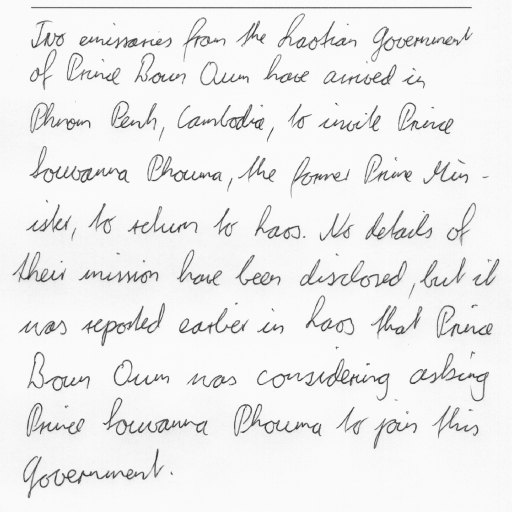

In [120]:
img = open_image(PATH/'test/a03-014.png'); img.resize(512)

In [121]:
res = learn.predict(img)

In [55]:
print(str(res[0]))

Two embraces from the Taxation Government
of Prince Brown have arrived in
Phnom Penh, Canada, to invite Prince
Bavaria Phouma, the former Prime Miss-
sites, to return to Laos. No details of
their mission have been disclosed, but it
was reported earlier in has that Prince
Brown Owen was considering asking
Prince Souvanna Phouma to join this
Government.


In [ ]:
del learn

In [ ]:
# baseline
# 8.12 s ± 262 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# quantized
# 10.9 s ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# traced
# 557 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# quantized, traced
# 630 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Compare pytorch to fastai for inference

In [16]:
import torchvision.transforms as transforms
tfm = transforms.Compose([transforms.Resize(512),transforms.ToTensor()])

In [30]:
im = PIL.Image.open(PATH/'test/a03-014.png').convert('L').convert('RGB')
b = tfm(im).unsqueeze(0)

In [35]:
model = torch.jit.load(str(PATH/'quantized_graph_export.pth'), map_location='cpu')

In [36]:
out = model(b)

In [38]:
p = torch.argmax(out, dim=-1, keepdim=False)

In [40]:
p[0]

tensor([   6,   99,    7,   33,   74, 2727, 2799,    7,   62,    7,   34,    7,
           6, 9730,    7,    6,  331,    4,   39,    7,    6, 1576,    7,    6,
         823,    7,   77,    7, 1464,    7,   41,    4,    6,  886,   93,   64,
           7,    6, 1117,   79,   35,    7,    6, 3252,   35,    7,   42,    7,
          41,  118,   51,   33,    7,    6, 1576,    4,    6,  107, 4523, 2510,
           7,    6, 4119,  671,   38,   35,    7,   34,    7,  509,    7,    6,
        2442,    7,    6, 1537,    7,   27,    4, 2992,   35,    7,   42,    7,
         702,    7,   42,    7,    6,  295,  715,   37,    7,    6,   91,    7,
        2962,    7,   39,    4,   86,    7, 1348,    7,   77,    7,  105,    7,
          48,   47, 1602,   35,    7,   66,    7,   51,    4,   46,    7,  828,
           7, 1046,    7,   41,    7,   89,    7,   49,    7,    6, 1576,    4,
           6,  823,    7,    6, 1193,    7,   46,    7, 3768,    7, 4595,    4,
           6, 1576,    7,    6,  107, 45

In [41]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.Load(str(PATH/'spm_full_10k.model'))
# sp.SetEncodeExtraOptions("eos")
sp.SetDecodeExtraOptions("bos:eos")

True

In [42]:
def remove_cap_tokens(text):  # after decode
    text = re.sub(r'\[UP\]\w+', lambda m: m.group()[4:].upper(), text)  #cap entire word
    text = re.sub(r'\[MAJ\]\w?', lambda m: m.group()[5:].upper(), text) #cap first letter
    return text

In [44]:
def textify(sp, ids):
    return remove_cap_tokens(sp.DecodeIds(ids.tolist()))

In [47]:
print(textify(sp, p[0]))

Two envisaries from the Factories Government
of Prince Brown have arrived in
Phnom Penh, Cambridge, to invite Prince
Souvanna Phouma, the former Prime Miss -
sites, to return to Laos. Us details of
their mission have been disclosed, but it
was reported earlier in has that Prince
Brown Ann was considering asking
Prince Souvanna Phouma to join this
Government.


In [11]:
data = load_data(PATH, 'data.pkl')

In [135]:
# compare bare pytorch to fastai (CER) for inference
# generally, fastai performs better...

for fname,arr in zip(data.train_ds.items, data.train_ds.y):
    targ = str(arr)
    print(fname)
    print(targ)
    y = torch.from_numpy(arr.data)
    # pytorch
    im = PIL.Image.open(fname).convert('L').convert('RGB')
    b = tfm(im).unsqueeze(0)
    out1 = model(b)
    p = torch.argmax(out1, dim=-1, keepdim=False)
    p = textify(sp, p[0])
    print('pytorch: %.3f CER' % (Lev.distance(targ, p)/len(targ)))
    
    # fastai
    im = open_image(fname)
    out2 = str(learn.predict(im)[0])
    print(' fastai: %.3f CER' % (Lev.distance(targ, out2)/len(targ)))

data/IAM_handwriting/paragraphs/r06-115.png
Catherine looked at the books lying
around his room, and asked if she
might borrow the stories of Isaac Babel
to read on the train. Catherine is 13.
I suggested she might find them dif-
ficult, but she said, "Philip reads them,
doesn't he?" During the journey I read
newspapers and watched her pretty
frowning face as she turned the
pages of Babel, for she was determined
to let nothing get between her and
pytorch: 0.126 CER
 fastai: 0.020 CER
data/IAM_handwriting/paragraphs/g06-042j.png
Nor is this to be wondered at, for even today,
in the 1960s, no cure has been found for
the 6tic douloureux. As early as 1830, when
Anglesey believed himself to be on the
point of death, the new German curative
method known as homoeopathy had been
brought to his notice.
pytorch: 0.019 CER
 fastai: 0.000 CER
data/IAM_handwriting/paragraphs/b06-071.png
Ordinary working people will never
rally to defend a policy founded on
political chicanery or elect a Labour
Gove

# Benchmarks

## Loss and Metrics

In [18]:
import time as tt
import Levenshtein as Lev

In [19]:
def cer(preds, targs, fn):
    bs = targs.size(0)
    res = torch.argmax(preds, dim=-1)
    error = 0
    for i in range(bs):
        p = str(fn(res[i]))
        t = str(fn(targs[i]))
        error += Lev.distance(t, p)/(len(t) or 1)
    return error, bs

In [20]:
torch._C.set_grad_enabled(False)
torch.is_grad_enabled()

# this replaces the torch.no_grad context manager in benchmark function!
# -> causing errors with benchmark timing

False

In [26]:
def benchmark(model, data, num=10):
    x,y = next(iter(data.train_dl))
    model.eval()
    error = 0
    elapsed = 0
    toks = 0
    for i in progress_bar(range(num)):
        #with torch.no_grad():  # this is necessary for jit quantized w/ maxpool2d
        start = tt.time()
        out = model(x[i:i+1])
        end = tt.time()
        elapsed += (end-start)
        toks += out.size(1)
        error += cer(out, y[i:i+1], data.y.reconstruct)[0]
    #print('%.3f CER' % (error/num) + ', ' + '%.2f secs/img' % (elapsed/num) + ', ' + '%.2f MB' % size_of_model(model))
    print('%.3f CER' % (error/num) + ', ' + '%.2f toks/sec' % (toks/elapsed) + ', ' + '%.2f MB' % size_of_model(model))

In [ ]:
# models = {'baseline': baseline, 'baseline jit': baseline_jit, 'tfmr quantized': tfmr_q,
#           'tfmr quantized jit': tfmr_q_jit, 'full quantized': full, 'full quantized jit': full_jit,
#           'full alt': full_alt, 'full alt jit': full_alt_jit}

In [ ]:
# for k,mod in models.items():
#     benchmark(mod, data)
#     print(k)

In [58]:
model = torch.load(PATH/'baseline.pth')

In [22]:
jit_model = torch.jit.load(str(PATH/'fully_quantized_graph_export.pth'), map_location='cpu')

In [28]:
benchmark(jit_model, data)

0.045 CER, 15.47 toks/sec, 20.70 MB


- 0.077 CER, 18.38 secs/img, 203.60 MB  baseline
- 0.062 CER, 13.39 secs/img, 203.60 MB  baseline jit
- 0.043 CER, 11.04 secs/img, 100.19 MB  tfmr quantized (dynamic)
- 0.040 CER, 12.72 secs/img,  65.46 MB  tfmr quantized jit
- 0.037 CER, 11.91 secs/img,  66.68 MB  full quantization
- 0.045 CER, 11.31 secs/img,  20.70 MB  full quantization jit

quantization + TorchScript graphing yields ~10x decrease in model size 203.60MB to 20.70MB
and processing performance increase of 63% from 18.38 secs/img to 11.31 secs/img 